In [1]:
import sys
sys.path.append('./COOT/code')


In [2]:
from joblib import Parallel, delayed
from tqdm import tqdm
import collections
import ast
from scipy.stats import entropy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from sklearn.manifold import MDS
import hypernetx as hnx
from HyperCOT.hypercot import *
import cot
from diskcache import Cache


sns.set()

cache = Cache('./gw-cache')


In [3]:
def read_labels(path, dataset='ss-role'):
    label_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if dataset in ['ss-func', 'ss-role', 'roberta']:
                word_info, word_label = line.strip().split('\t')
                sent_info, word = word_info.split(':')
                sent_info = ast.literal_eval(sent_info)
                label_data.append([sent_info[0], sent_info[1], word, word_label])
            elif dataset == 'dep':
                word_pair, word_label = line.strip().split('\t')
                word_pair = word_pair.split('--')
                if len(word_pair) == 2:
                    word1, word2 = word_pair
                elif len(word_pair) == 3:
                    word1, word2 = word_pair[0], '--'
                sent_info = [0, 0]
                label_data.append([sent_info[0], sent_info[1], f'{word1}--{word2}', word_label])
            else:
                raise ValueError('Dataset not supported')

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def get_graph(dataset, dist_metric, filter, intervals, overlap, iteration, layer, datasplit, min_samples=3):
    # make request to local server at port 5000 at \graph
    # with the query: {params: 'ss-role_euclidean_l2_50_50', iteration: 0, layer: 12, datasplit: 'train'}
    # and save the response as a variable
    cache_key = f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}_{iteration}_{layer}_{datasplit}_{min_samples}'

    if cache_key in cache:
        graph = cache.get(cache_key)
    else:
        r = requests.get(
            'http://localhost:5000/graph',
            params={
                'dataset': dataset,
                'epoch': iteration,
                'layer': layer,
                'dataSplit': datasplit,
                'metric': dist_metric,
                'filter': filter,
                'overlap': overlap,
                'intervals': intervals,
                'minSamples': min_samples,
            })
        # params={'params': f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}', 'iteration': iteration, 'layer': layer,
        # 'datasplit': datasplit})
        r.raise_for_status()
        data = r.json()
        graph = nx.json_graph.node_link_graph(data['graph'])
        cache[cache_key] = graph

    return graph


def get_incidence(graph):
    return nx.incidence_matrix(graph).toarray()


In [4]:
EPOCHS = list(range(0, 176, 5)) + [176]


def get_graphs(dataset, dist_metric, filter, intervals, overlap, layer, datasplit):
    graphs = []

    for epoch in tqdm(EPOCHS, desc=f'Computing mapper graphs [Layer {layer}]'):
        graph = get_graph(dataset, dist_metric, filter, intervals, overlap, epoch, layer, datasplit)
        graphs.append(graph)

    return graphs


def gw_distances(graphs):
    layerwise_costs = {}

    costs = np.zeros((len(graphs), len(graphs)))
    g2 = graphs[0]

    for i, g1 in tqdm(enumerate(graphs), desc='Computing costs', total=len(graphs)):
        for g2 in graphs[i + 1:]:
            I1, I2 = get_incidence(g1), get_incidence(g2)
            Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
            costs[i, i + 1] = cost
            costs[i + 1, i] = cost

    return costs


def memberPointIds(node_data):
    return [str(x['memberId']) for x in node_data['memberPoints']]


def induced_hypergraph(graph):
    # hypergraph is a dictionary ofd point_id: [node_ids it is member of]

    hypergraph = {}

    for node_num, (node_id, node_data) in enumerate(graph.nodes(data=True)):
        hypergraph[node_num] = memberPointIds(node_data)

    return hnx.Hypergraph(hypergraph)


def get_w_v(hgraph, sub_inf=True, sub_inf_val=0):
    # hgraph = induced_hypergraph(graph)
    hgraph_dual = get_hgraph_dual(hgraph)
    line_graph = convert_to_line_graph(hgraph.incidence_dict)

    v = get_v(hgraph.incidence_dict, hgraph_dual.incidence_dict)
    w = get_omega(hgraph, hgraph_dual, line_graph, weight_type='intersection_size')

    if sub_inf:
        w[w == np.inf] = sub_inf_val

    return w, v


def parallel_hgraphs(graphs):
    hgraphs = Parallel(n_jobs=-1)(delayed(induced_hypergraph)(graph) for graph in tqdm(graphs))
    return hgraphs
    

In [5]:
layerwise_graphs = {
    '12': get_graphs('ss-role', 'euclidean', 'l2', 50, 50, 12, 'train'),
    '9': get_graphs('ss-role', 'euclidean', 'l2', 50, 50, 9, 'train'),
    '4': get_graphs('ss-role', 'euclidean', 'l2', 50, 50, 6, 'train'),
    '1': get_graphs('ss-role', 'euclidean', 'l2', 50, 50, 1, 'train'),
}

layerwise_hgraphs = {
    '12': parallel_hgraphs(layerwise_graphs['12']),
    '9': parallel_hgraphs(layerwise_graphs['9']),
    '4': parallel_hgraphs(layerwise_graphs['4']),
    '1': parallel_hgraphs(layerwise_graphs['1']),
    # '12': [induced_hypergraph(g) for g in tqdm(layerwise_graphs['12'], desc='Hypgraph for Layer 12')],
    # '9': [induced_hypergraph(g) for g in tqdm(layerwise_graphs['9'], desc='Hypgraph for Layer 9')],
    # '4': [induced_hypergraph(g) for g in tqdm(layerwise_graphs['4'], desc='Hypgraph for Layer 4)],
    # '1': [induced_hypergraph(g) for g in tqdm(layerwise_graphs['1'], desc='Hypgraph for Layer 1')],
}


100%|██████████| 37/37 [00:19<00:00,  1.92it/s]


In [6]:
def compute_gw_parallel(hgraphs, base_graph):
    def compute_cost(w0, v0, w1, v1):
        Ts, Tv, cost = cot.cot_numpy(w0, w1, v1=v0, v2=v1, niter=2000, verbose=False)
        return cost

    wn_vn = []

    wn_vn = Parallel(n_jobs=-1)(delayed(get_w_v)(hgraph) for hgraph in tqdm(hgraphs, desc='Computing W, V'))
    # for i, hgraph in tqdm(enumerate(hgraphs), total=len(hgraphs), desc='Compute W, V'):
    #     w1, v1 = get_w_v(hgraph)
    #     wn_vn.append((w1, v1))

    if base_graph == 'ZERO':
        w0, v0 = get_w_v(hgraphs[0])
        costs = Parallel(n_jobs=-1)(delayed(compute_cost)(w0, v0, wn_vn[i][0], wn_vn[i][1]) for i in tqdm(range(len(hgraphs))))
    elif base_graph == 'PREV':
        costs = [0]
        costs = Parallel(n_jobs=-1)(delayed(compute_cost)(wn_vn[i][0], wn_vn[i][1],
                                                          wn_vn[i - 1][0], wn_vn[i - 1][1]) for i in tqdm(range(1, len(hgraphs))))

    return costs


layerwise_costs = {}

layerwise_costs['12'] = compute_gw_parallel(layerwise_hgraphs['12'], 'ZERO')
layerwise_costs['9'] = compute_gw_parallel(layerwise_hgraphs['9'], 'ZERO')
layerwise_costs['4'] = compute_gw_parallel(layerwise_hgraphs['4'], 'ZERO')
layerwise_costs['1'] = compute_gw_parallel(layerwise_hgraphs['1'], 'ZERO')


100%|██████████| 37/37 [01:11<00:00,  1.94s/it]


In [ ]:
layerwise_costs = {}

METHOD = 'HGRAPH'
# METHOD = 'INCIDENCE'
# BASE_GRAPH = 'PREV'
BASE_GRAPH = 'ZERO'

for layer, graphs in layerwise_graphs.items():
    if METHOD == 'HGRAPH':
        # h0 = induced_hypergraph(graphs[0])
        # h0_dual = get_hgraph_dual(h0)

        # l0 = convert_to_line_graph(h0.incidence_dict)

        # v0 = get_v(h0.incidence_dict, h0_dual.incidence_dict)
        # w0 = get_omega(h0, h0_dual, l0, 'intersection_size')
        # w0[w0 == np.inf] = 0
        hgraph = layerwise_hgraphs[layer][0]
        w0, v0 = get_w_v(hgraph)
    elif METHOD == 'INCIDENCE':
        I0 = get_incidence(graphs[0])

    costs = []

    for graph in tqdm(graphs, desc=layer):
        if METHOD == 'HGRAPH':
            # h1 = induced_hypergraph(graph)
            # h1_dual = get_hgraph_dual(h1)

            # l1 = convert_to_line_graph(h1.incidence_dict)

            # v1 = get_v(h1.incidence_dict, h1_dual.incidence_dict)
            # w1 = get_omega(h1, h1_dual, l1, 'intersection_size')
            # w1[w1 == np.inf] = 0
            hgraph = layerwise_hgraphs[layer][graphs.index(graph)]
            w1, v1 = get_w_v(hgraph)
            Ts, Tv, cost = cot.cot_numpy(w0, w1, v1=v0, v2=v1, niter=2000, verbose=False)

            if BASE_GRAPH == 'PREV':
                w0, v0 = w1, v1
        elif METHOD == 'INCIDENCE':
            I1 = get_incidence(graph)
            Ts, Tv, cost = cot.cot_numpy(I0, I1, niter=2000, verbose=False)

            if BASE_GRAPH == 'PREV':
                I0 = I1

        costs.append(cost)

    layerwise_costs[layer] = costs


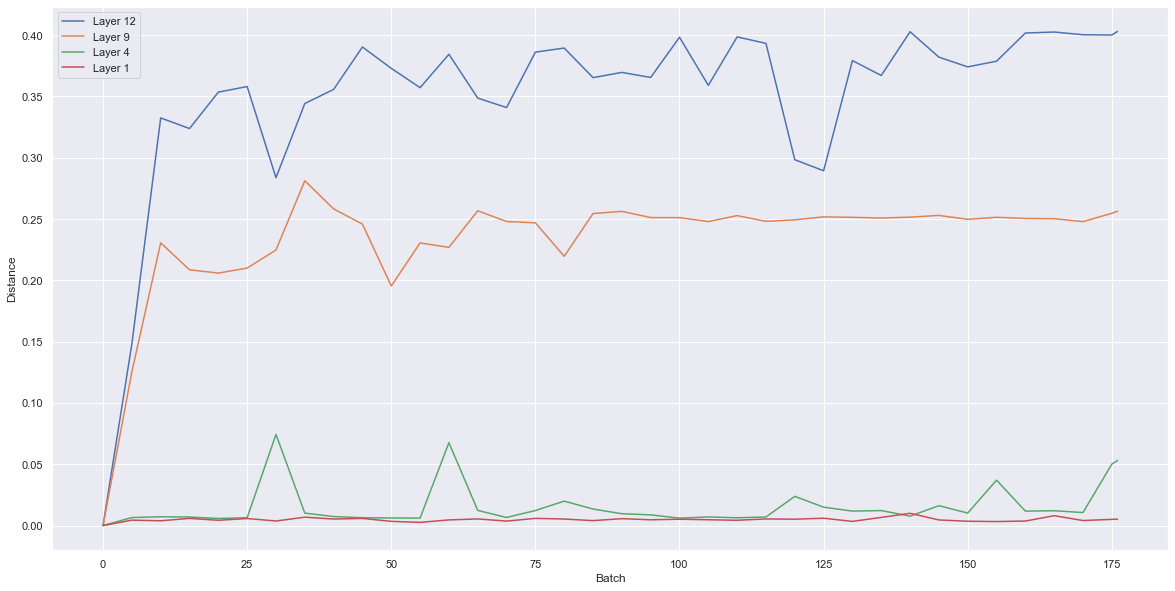

In [8]:
def plot_layerwise_costs(layerwise_costs, ax=None):
    for layer, costs in layerwise_costs.items():
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(EPOCHS, costs, label=f'Layer {layer}')
        else:
            ax.plot(EPOCHS, costs, label=f'Layer {layer}')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Distance')
    plt.legend()


# HGRAPH
fig, ax = plt.subplots(figsize=(20, 10))
plot_layerwise_costs(layerwise_costs, ax)
plt.savefig('./images/gramov-wasserstein/gw-ss-role-hgraph.png', dpi=300)


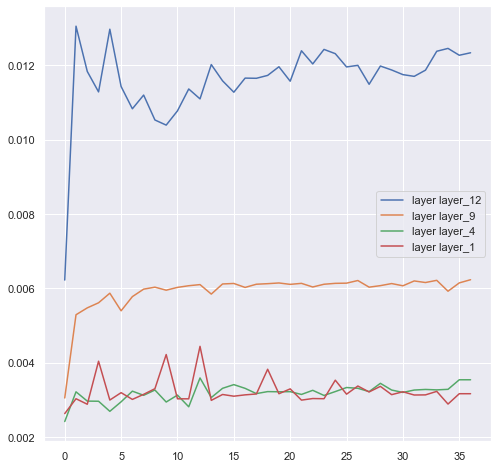

In [10]:
# INCIDENCE
plot_layerwise_costs(layerwise_costs)


In [27]:
costs = []

for graph in tqdm(graphs):
    h1 = induced_hypergraph(graph)
    h1_dual = get_hgraph_dual(h1)
    v1 = get_v(h1.incidence_dict, h1_dual.incidence_dict)
    Ts, Tv, cost = cot.cot_numpy(h0.incidence_matrix().toarray(), h1.incidence_matrix().toarray(), v1=v0, v2=v1, niter=1000, verbose=False)
    costs.append(cost)


100%|██████████| 37/37 [10:28<00:00, 16.98s/it]


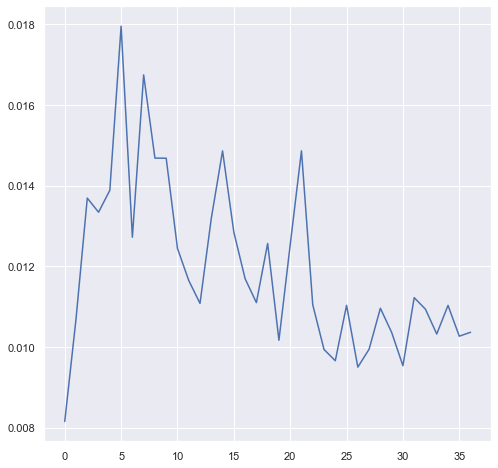

In [23]:
plt.plot(costs)


In [ ]:
# Get the mapper graph for 176 epochs
graphs = []

# compute the induced hypergraph
# Key: mapper_node_id, value: point_ids of the points in the mapper node
induced_hypergraphs = []

# for two hgraph h1, h2
# computer v1, v2, w1, and w2

cot_numpy(w1, w2, v0, v1)

# if convergence issues, set random_init
cot.cot_


In [25]:
graphs = get_graphs('ss-role', 'euclidean', 'l2', 50, 50, 12, 'train')
gw_matrix = gw_distances(graphs)


# perform MDS on the gw matrix

coords = MDS(n_components=2, dissimilarity='precomputed').fit_transform(gw_matrix)

# plot the coords and labels
plt.figure(figsize=(10, 10))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=range(len(graphs)), s=200)


Computing costs:   0%|          | 0/37 [18:25<?, ?it/s]


KeyboardInterrupt: 

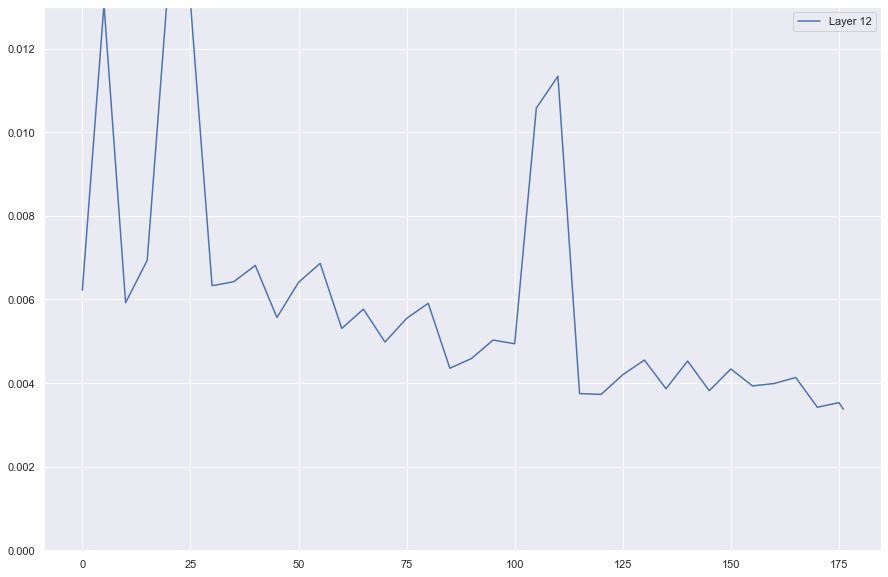

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_ylim(0, 0.013)

# plt.show()

plot_layerwise_costs(layerwise_costs)
plt.savefig('./images/gramov-wasserstein/ss-role-layer1_5_9_12.png', dpi=300)


In [32]:


# cost_wrt_zero = []

# for graph in graphs:
#     g1, g2 = graphs[0], graph
#     I1, I2 = get_incidence(g1), get_incidence(g2)
#     Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
#     cost_wrt_zero.append(cost)

# costs = np.zeros((len(graphs), len(graphs)))

# for i in tqdm(range(len(graphs))):
#     for j in range(i + 1, len(graphs)):
#         g1, g2 = graphs[i], graphs[j]
#         I1, I2 = get_incidence(g1), get_incidence(g2)
#         Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
#         costs[i, j] = cost
#         costs[j, i] = cost


# g1 = get_graph('ss-func', 'euclidean', 'l2', 50, 50, 0, 12, 'train')
# I1 = np.array(nx.incidence_matrix(g1).todense().T)
# costs = []

# for epoch in tqdm(range(0, 176, 5)):
#     g2 = get_graph('ss-role', 'euclidean', 'l2', 50, 50, epoch, 12, 'train')
#     I2 = np.array(nx.incidence_matrix(g2).todense().T)
#     Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=1000, verbose=False)
#     costs.append(cost)


<AxesSubplot:>

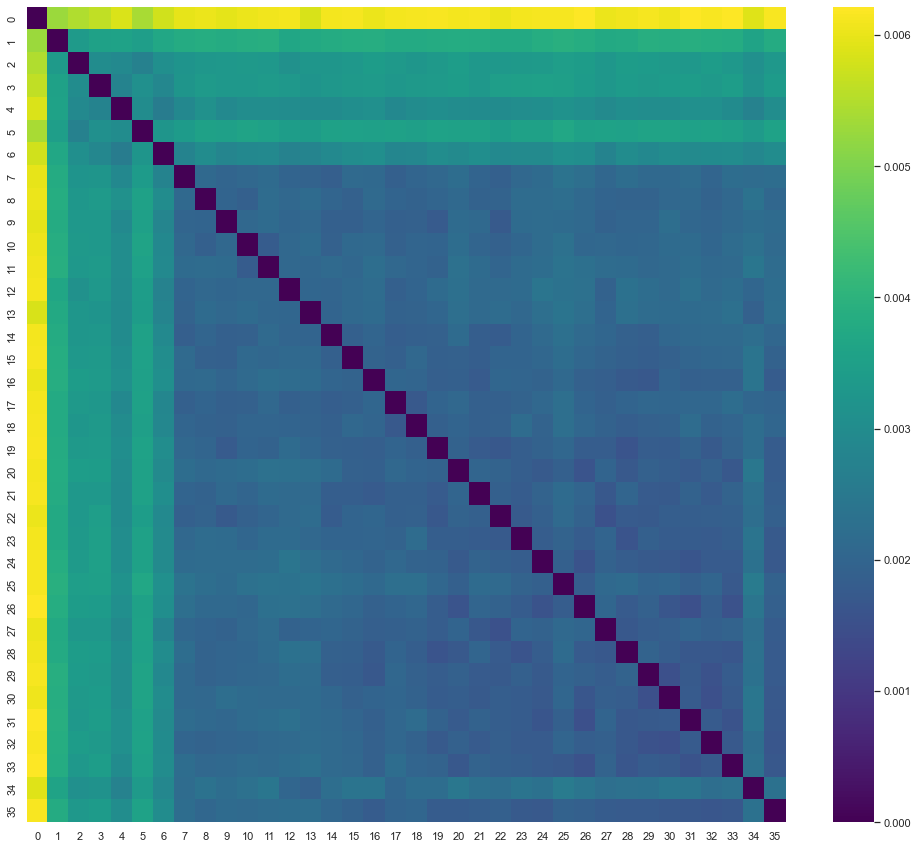

In [24]:
# plot heatmap of costs
plt.figure(figsize=(17, 15))
sns.heatmap(costs, cmap='viridis')


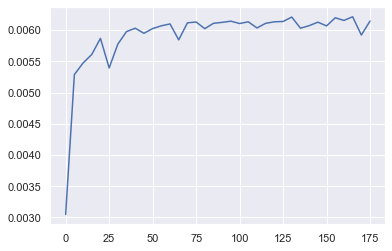

In [34]:
# plot change in costs between epochs
plt.plot(np.arange(0, 176, 5), cost_wrt_zero)


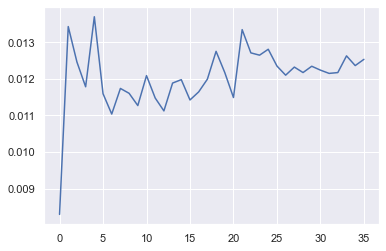

In [18]:
plt.plot(costs)


In [10]:
I1, I2 = np.array(nx.incidence_matrix(g1).todense().T), np.array(nx.incidence_matrix(g2).todense().T)
W1, W2 = nx.floyd_warshall_numpy(g1), nx.floyd_warshall_numpy(g2)


In [11]:
(len(g1.nodes()), len(g1.edges())), (len(g2.nodes()), len(g2.edges()))


((124, 70), (282, 208))

In [12]:
Ts, Tv, cost = cot.cot_numpy(I1, I2)


Delta: 0.1214095797313286  Loss: 0.015570782454790677
Delta: 0.1103153501009839  Loss: 0.013790017749351983
Delta: 0.09592517039020873  Loss: 0.01310493298739694
Delta: 0.08156380542979949  Loss: 0.012970414394573611
Delta: 0.07655017625686424  Loss: 0.012927345189699329
Delta: 0.07954988069608204  Loss: 0.012860046610904525
Delta: 0.07934247378916377  Loss: 0.012784325889164587
Delta: 0.0789928750991781  Loss: 0.012692562242150424
Delta: 0.074982919378144  Loss: 0.012651017193741959
Delta: 0.07542132802041507  Loss: 0.012558090788186864


In [13]:
cost


0.012558090788186864